In [1]:
import os
import editdistance
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = os.path.join('morse_dataset', 'morse_dataset')
PREPROCESS = False
TRAIN = False
DEBUG = False

## Предобработка данных

### Почему спектрограмма?

Сигналы Морзе — это последовательности коротких и длинных звуков, закодированных на фиксированной (или почти фиксированной) частоте. Перевод аудио в частотно-временное представление (спектрограмму) позволяет нам буквально увидеть сигнал: когда и на каких частотах он проявляется. При этом предпочтение отдано обычной, а не mel спектрограмме, чтобы она своим действием не "сплющивала" испульсный характер сигнала.

Грубо говоря, мы превращаем звук в картинку — и дальше можем применять визуальные эвристики и архитектуры из компьютерного зрения (например, CNN). Это даёт больше гибкости в извлечении паттернов, чем работа напрямую с волной.

### Интуиция при предобработке

- Морзе — узкополосный сигнал, и в пределах одного аудиофайла его частота почти не меняется. Поэтому важно выбрать такие параметры спектрограммы, чтобы «пик» в нужном частотном бинне был чётко виден. Это требует хорошей частотной дискретности ```(n_fft=1024, hop_length=128)```.
- Я, конечно, не слушал все 35000 аудиофайлов (и, надеюсь, никто не слушал), но предполагаю, что небольшие колебания частоты могут быть. Поэтому важно не обрезать спектр слишком жёстко, но всё же убрать далёкие частоты, где, скорее всего, только шум. Это снижает размер входа и ускоряет обучение, сохраняя максимум пользы.
- После обрезки остаётся ещё довольно много слабых компонентов — возможно, шум, возможно, эхо. Чтобы от них избавиться, ввожу пороговую фильтрацию: всё, что ниже $\alpha \cdot \mathbb{E}[energy]$ — зануляется. Порог ```alpha=0.1``` подобран вручную — он убивает явный мусор, но не трогает слабые, но стабильные сигналы.
- Чтобы модель не зависела от громкости, я нормализую амплитуду до $[0, 1]$. Это даёт модели возможность сравнивать сигналы «по форме», а не по уровню громкости.

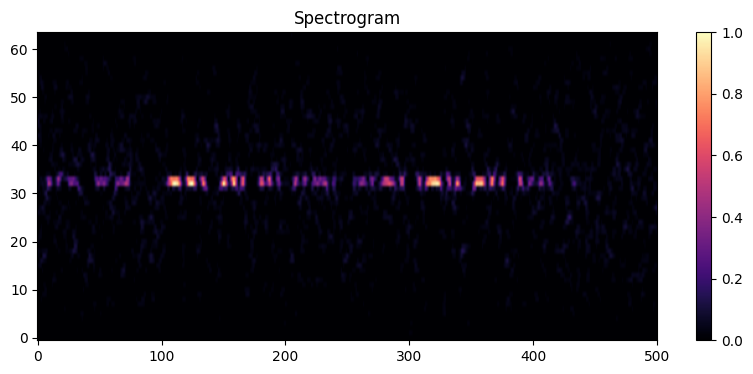

In [3]:
from morse import MorsePreprocessing

waveform, sample_rate = torchaudio.load(os.path.join(DATASET_PATH, '21600.opus'))
transform = MorsePreprocessing(alpha=0.1, n_fft=1024, hop_length=128, margin=32, power=2)
spec = transform(waveform)

plt.figure(figsize=(10, 4))
plt.imshow(spec[0,:,:].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Spectrogram')
plt.colorbar()
plt.show()

### Подготовка датасета

После извлечения спектрограммы для каждого аудиофайла, необходимо было организовать датасет в удобный формат для обучения. Я реализовал функцию preprocess_dataset, которая выполняет следующие шаги:

- Метки берутся из файла ```train.csv``` и представляют собой текстовые сообщения на кириллице
- Каждое сообщение преобразуется в последовательность точек и тире с помощью словаря ```morse_dict```
- С помощью трансформера ```MorsePreprocessing``` аудиофайлы .opus преобразуются в спектрограммы
- Используется ```train_test_split``` из sklearn с фиксированным ```random_state```, чтобы получить стабильный валидационный сплит (15%)
- Примеры сохраняются, чтобы при обучении просто загружать их с диска (иначе CPU выступает бутылочным горлышком)

In [4]:
from preprocessing import preprocess_dataset

df = pd.read_csv('train.csv')
labels_dict = {
        f"{row['id']}": row['message']
        for _, row in df.iterrows()
    }

if PREPROCESS:
    preprocess_dataset(DATASET_PATH, "data_preprocessed", labels_dict, transform)

### Dataset и DataLoader

Для обучения модели с CTC-лоссом важно обеспечить:

- корректную токенизацию выходной последовательности
- передачу длины как входов ```input_lengths```, так и целевых меток ```target_lengths```
- паддинг спектрограмм по времени внутри батча

In [5]:
from preprocessing import PreprocessedDataset
from morse import SpecAugment

c2i = {
    '<blank>': 0,
    '.': 1,
    '-': 2,
    ' ': 3,
    '/': 4
}
i2c = {v: k for k, v in c2i.items()}

train_dataset = PreprocessedDataset('data_preprocessed/train', c2i, transform=SpecAugment(freq_mask_param=1, time_mask_param=20))
#train_dataset = PreprocessedDataset('data_preprocessed/train', c2i)
val_dataset = PreprocessedDataset('data_preprocessed/val', c2i)

### Collate-функция

Поскольку спектрограммы имеют разную длину по времени, перед подачей в модель они паддятся по временной оси:

- Спектрограммы транспонируются в форму [time, features] для pad_sequence
- Используется ```pad_sequence(..., batch_first=True)```, чтобы получить итоговую размерность $[B, T, F]$
- Метки конкатенируются в один длинный вектор, как требуется для ```nn.CTCLoss```
- Длины входов и выходов сохраняются для корректной работы CTC

In [6]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    features, targets, input_lengths, target_lengths = zip(*batch)

    features = [f.transpose(0, 1) for f in features]

    padded_features = pad_sequence(features, batch_first=True)
    padded_targets = torch.cat(targets)

    input_lengths = torch.tensor([f.shape[0] for f in features], dtype=torch.long)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return padded_features, padded_targets, input_lengths, target_lengths

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

## Архитектура модели

Для распознавания последовательностей Морзе-кода по спектрограмме я использовал Conformer — современную архитектуру, сочетающую attention-механизмы и depthwise-свёртки. Это позволяет одновременно учитывать как глобальные зависимости во времени, так и локальные паттерны, характерные для сигналов Морзе (точки, тире, паузы).

### Почему Conformer?

Выбор архитектуры Conformer был сделан осознанно — с учётом природы задачи, её схожести с ASR, а также современных тенденций в deep learning.
Распознавание Морзе с аудиофайлов по сути представляет собой специальный случай автоматического распознавания речи (ASR):

- есть входной аудиосигнал,
- нужно извлечь последовательность символов (в нашем случае — коды Морзе, а не слова),
- важно учитывать временную структуру сигнала: продолжительность, паузы, ритм.

Так как Conformer — это архитектура, разработанная именно для ASR, её применение к задаче Морзе выглядит логичным и оправданным. Трансформеры доказали свою эффективность во множестве задач. Механизм внимания в совокупности с feed-forward слоями позволяют добиваться высокой обобщающей способности на сложных задачах. Добавляя к ним CNN и Residual блоки можно усидеть сразу на 2 стульях: воспользоваться преимуществами работы с изображениями и временными рядами.

### А чем не устроили RNN?

До появления трансформеров основным выбором для задач распознавания последовательностей были рекуррентные нейросети — RNN, GRU, LSTM. Они действительно хорошо решали задачи, где важно учитывать порядок и временные зависимости, и долгое время были стандартом в ASR, NLP и других областях.

LSTM и GRU работают последовательно по времени, т.е. каждое новое состояние зависит от предыдущего. Это означает:

- невозможность параллелизации по временной оси;
- долгую и неустойчивую тренировку на длинных последовательностях;
- накопление ошибок и затухание градиентов на больших расстояниях (даже с gate-механизмами).

### Но есть нюанс

Любая из архитектур, упомянутых выше "задыхается", когда получает на вход длинную последовательность. RNN просто "забудут" последовательность даже при использовании bidirectional и gate-механизмов, а Conformer со своими блоками внимания "скушает" всю память. Емкостная сложность: $O(T^2)$. Благо все аудиофайлы (кроме последних 17) не превышают длиной 8 секунд и по этому поводу можно расслабиться. При выбранных параметрах спектрограммы итоговая длина входа оказывается вполне разумной — и без пиков по памяти даже на обычной 12GB видеокарте.

Если бы моделью требовалось обрабатывать реально длинные сигналы (например, многоминутные записи радиоперехвата), то стандартные практики из мира ASR могли бы помочь:

- Chunk-based decoding — нарезка входа на фиксированные перекрывающиеся чанки;
- Streaming Inference — подача сигнала «на лету» (как у Whisper или DeepSpeech);



In [8]:
from morse import MorseConformer

model = MorseConformer(
    input_dim=64,
    output_dim=5,
    embedding_dim=64,
    ffn_dim=256,
    num_layers=8,
    num_heads=4,
    dropout=0.2
).to('cuda')

## Обучение

### Целевая функция: CTC Loss

Поскольку на вход подаётся спектрограмма, а на выходе — последовательность символов Морзе без выравнивания по времени, используется CTC Loss (Connectionist Temporal Classification).

CTC обучает модель максимизировать суммарное правдоподобие правильной выходной последовательности, с учётом всех возможных допустимых выравниваний.

Это делает её отличным приближением для нашей метрики — Mean Levenshtein Distance. К сожалению, сам Левенштейн не дифференцируем, и напрямую оптимизировать его невозможно. CTC же минимизирует лог-вероятность ошибок в последовательности, что близко по сути.

### Процесс обучения

- Используется AdamW — оптимизатор с weight decay, который даёт хорошую стабильность и контроль за переобучением
- Применяется linearly increasing learning rate (warm-up) в первые 500 шагов — популярный трюк в трансформерах, позволяющий избежать «взрыва градиентов» на старте
- Чтобы избежать переобучения и не тратить ресурсы впустую, реализован EarlyStopping
- На этапе отладки применялась KFold-валидация ```n_splits=5``` для оценки устойчивости модели к разным сплитам. Это позволяет получить оценку дисперсии ошибки и убедиться, что результат не «подгонка» под конкретную валидационную выборку

> P.S Да, я знаю, что в PyTorch Lightning есть встроенная реализация ранней остановки, но из-за учебной нагрузки времени на изучение новой библиотеки не было. Так что сделал руками


In [9]:
from train import train
from train import cross_val_scores

if DEBUG:
    scores = cross_val_scores(model, train_dataset, train, collate_fn, num_epochs=100, patience=5)
    
    print(f'Scores: {scores}')
    print(f'Mean: {np.mean(scores)}')
    print(f'Std: {np.std(scores)}')

In [10]:
if TRAIN:
    train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=100,
        patience=5
    )

model.load_state_dict(torch.load('models/best_model.pt', map_location='cuda'))

<All keys matched successfully>

## Инференс и генерация сабмита

Финальный этап — преобразование выходов модели в понятный текст и формирование .csv для отправки на соревнование.

### Декодер

Для перевода логитов модели в последовательности символов я использовал CTC Beam Search Decoder из ```torchaudio.models.decoder```. Он учитывает всю вероятностную структуру выходной последовательности, а не просто делает локальные предсказания.

> Если говорить проще, это перебор с отсечением: перебирается множество возможных вариантов, но сохраняются только самые перспективные ```(beam_size=10)```, с наибольшим суммарным log-likelihood.

Это даёт более устойчивый и осмысленный результат, особенно при длинных выходных последовательностях и близких по вероятности символах.

### Почему не greedy?

Он выбирает наиболее вероятный символ на каждом шаге — локально, но не обязательно глобально оптимально. Это может приводить к ошибкам. Beam search помогает избежать этих проблем за счёт оценки правдоподобия всей последовательности целиком, а не только отдельных шагов.

In [11]:
from torchaudio.models.decoder import ctc_decoder

labels = list(c2i.keys())
decoder = ctc_decoder(
    lexicon=None,
    tokens=labels,
    beam_size=10,
    blank_token='<blank>',
    unk_word='<blank>',
    sil_token='<blank>'
)

In [12]:
from preprocessing import preprocess_audio
from preprocessing import decode_from_morse
from torch.nn.functional import log_softmax

def submit():
    model.eval()
    submission = []
    
    target_files = sorted([
        f for f in os.listdir(DATASET_PATH)
        if f.endswith('.opus') and 30001 <= int(os.path.splitext(f)[0]) <= 35000
    ], key=lambda x: int(os.path.splitext(x)[0]))
    
    with torch.no_grad():
        for fname in target_files:
            path = os.path.join(DATASET_PATH, fname)
            mel = preprocess_audio(path, transform)
            mel = mel.transpose(0, 1).unsqueeze(0).to('cuda')
            input_len = torch.tensor([mel.shape[1]], device='cuda')
    
            logits = model(mel)
            log_probs = log_softmax(logits, dim=-1)
            log_probs_btc = log_probs.transpose(0, 1)
            
            decoded_output = decoder(log_probs_btc.cpu(), input_len.cpu())
            decoded_morse = ''.join([labels[token.item()] for token in decoded_output[0][0].tokens])
            decoded_text = decode_from_morse(decoded_morse)
    
            submission.append({
                "id": fname,
                "message": decoded_text
            })
    
    df = pd.DataFrame(submission)
    df.to_csv("submission.csv", index=False)

submit()

## Оценка качества на валидации

Для оценки производительности модели на валидации я использовал:

- CTC Loss — внутреннюю loss-функцию, с которой обучалась модель
- Mean Levenshtein Distance — приближённую к конкурсной метрике, измеряющую расстояние между предсказанным и реальным сообщением

In [13]:
from preprocessing import decode_from_morse
from torch.nn.functional import log_softmax
from torch.nn import CTCLoss

model.eval()
ctc_loss_fn = CTCLoss(blank=0, zero_infinity=True)
val_losses = []
levenshtein_scores = []

with torch.no_grad():
    for features, targets, input_lengths, target_lengths in val_loader:
        features = features.to('cuda')
        targets = targets.to('cuda')
        input_lengths = input_lengths.to('cuda')
        target_lengths = target_lengths.to('cuda')
        
        log_probs = model(features, input_lengths)
        log_probs = log_softmax(log_probs, dim=-1)
        
        loss = ctc_loss_fn(log_probs, targets, input_lengths, target_lengths)
        val_losses.append(loss.item())
        
        log_probs_btc = log_probs.transpose(0, 1)
        
        decoded_output = decoder(log_probs_btc.cpu().contiguous(), input_lengths.cpu())
        decoded_batch = [''.join([labels[token.item()] for token in hypo[0].tokens]) for hypo in decoded_output]
        target_batch = []
        start = 0
        
        for length in target_lengths:
            length = int(length)
            target_seq = targets[start:start + length]
            text = ''.join([i2c[int(c)] for c in target_seq])
            target_batch.append(text)
            start += length
        
        for pred, true in zip(decoded_batch, target_batch):
            dist = editdistance.eval(decode_from_morse(pred), decode_from_morse(true))
            levenshtein_scores.append(dist)

mean_val_loss = sum(val_losses) / len(val_loader)
mean_levenshtein = sum(levenshtein_scores) / len(levenshtein_scores)

print(f"Val CTC Loss: {mean_val_loss:.4f}")
print(f"Mean Levenshtein: {mean_levenshtein:.4f}")

Val CTC Loss: 0.0208
Mean Levenshtein: 0.2409


## Обработка специальных файлов

В датасете присутствуют 17 аудиофайлов с номерами 34984–35000, которые заметно длиннее остальных. Чтобы убедиться, что модель не "задыхается" на них, был проведён ручной прогон:

In [16]:
total_files = 35000

for file in range(total_files - 16, total_files + 1):
    path = os.path.join(DATASET_PATH, f'{file}.opus')

    waveform, sample_rate = torchaudio.load(path)

    mel = transform(waveform).squeeze(0)
    mel = mel.transpose(0, 1).unsqueeze(0).to('cuda')
    input_len = torch.tensor([mel.shape[1]], device='cuda')

    logits = model(mel)
    log_probs = log_softmax(logits, dim=-1)
    log_probs_btc = log_probs.transpose(0, 1)

    decoded_output = decoder(log_probs_btc.cpu(), input_len.cpu())
    decoded_morse = ''.join([labels[token.item()] for token in decoded_output[0][0].tokens])
    decoded_text = decode_from_morse(decoded_morse)

    print(f"{file}.opus,{decoded_text}")

34984.opus,ДАЗМТСОТИЕРСЫЕЖМЦ
34985.opus,ЕЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМ ЬТКТЧМЫН ДТЫМРГЗ ЕПИГ
34986.opus,АНХ ВСОЕГЬ Р ВКТДАМИРКШМДНИ ЗКНЖТА
34987.opus,ИДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНЮН ХНУСИ
34988.opus,ЕТЬТКП ДСЯНКМЫОЦ ИМК
34989.opus,КНОЬКМ СОФЫМОП ЬСЮНВМ
34990.opus,ИЛ ЬСОЕНДМЫМ ЙЫНУС ЙЫМЧАТУС ЬКТДЛХТ ЫМЖАЛШ ДЛУСВ М ЧТЫНАМБ
34991.opus,ИЛ ДАСДП ОСЮВНЫМ НЮЙГРГ УЫТУКНЩН
34992.opus,АС АТ ИСЧТИ КГЖБПЗЦ ЮН НПОСЬЗЕАДЗКАСВЕП ЮМИДСЫСХ
34993.opus,ОДЛ НЫЛСЕТ  Ь ЮЫН ВТ ЕРЫЦАМУП
34994.opus,АН ЖНОЕСУ ЬТКТВНЖМ ГЫМ4ТААСБ АН 75 РСЫСЯМРЫСД
34995.opus,ОДЦЮП ЬСВВТКЧМДНТЕОЦ ДКГЖАГЗ АТГЕСИМИЛИМ ЬНЫПЯНИМ АНХМШ СЬТКНЕСКСД
34996.opus,ОРСКС ИЛ ДАСДП ЬСОЕМУАТИ ЕНБАЛ КНРТЕАЛШ ВДМУНЕТЫТБ
34997.opus,ЖИСЧТИ СЕЬКИХУЕП ЮН ДНИМ5ЬНОМЕТЫПА55 ЖТЫАСР
34998.opus,ТОЫМ ДЛ ЬСЧТЫНТЕТ ДТКАГЕПОЦ ВСИСБ 
34999.opus,ОДТИОСЫАЯН ВНКМЕ ЧМЮАП РНЧВСИГ
35000.opus,ТЯ ЬТКТВНЖС


## Статистика модели

Общее количество параметров менее 1M

Это довольно лёгкая модель по современным меркам — особенно для задач обработки аудио. Такой размер позволяет:

- запускать обучение и инференс на обычной видеокарте (10–12 ГБ)
- быстро обучать модель с нуля без предобученных весов
- использовать Conformer даже на edge-устройствах или в проде (с оптимизациями).

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Общее количество параметров: {total_params}")

Общее количество параметров: 789509
